In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import torch
import tensorflow as tf
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from tensorflow.keras.models import Model
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from tensorflow.keras.models import Sequential
# from keras.layers import Layer
# from tensorflow.keras import activations
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers import Input, Concatenate, Conv1D, Conv2D, AveragePooling1D, AveragePooling2D, MaxPooling1D, MaxPooling2D
# from keras.layers import Lambda, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, Dense, LSTM, Dropout, TimeDistributed, Multiply, Reshape, RepeatVector, Bidirectional
# from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [3]:
df = pd.read_csv("../Datasets/vm_cpu_readings-file-1-of-195.csv")
columns = ['serial', 'Id', 'min_cpu', 'max_cpu', 'avg_cpu']
df.columns = columns
# df = df[:500000]
df.head(3)

,serial,Id,min_cpu,max_cpu,avg_cpu
0,0,gVb4X4iS13nJrM0KZsy7SrHzWAHix0CEPlK7/deV5vkwjt...,14.281488,20.028324,17.250655
1,0,f8BtQHczrXFjnVxWl8Hqm1kH9UD/8nCvtXCLiFvVRvamqa...,1.655368,23.138685,8.533818
2,0,8xjtVrJRJAyArNlbRgCftoNQOZiWl2eRP6uQavL9+6IULT...,47.501061,52.940579,50.045584


In [4]:
columns_to_check = ['max_cpu', 'avg_cpu']  
df = df[columns_to_check]

for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Dataset without outliers:\n", df)

Dataset without outliers:
            max_cpu    avg_cpu
0        20.028324  17.250655
1        23.138685   8.533818
3        12.889580   4.833578
4        20.426842  16.279067
5         3.863575   1.189029
...            ...        ...
9999991   5.095713   4.144911
9999992  36.503499  12.328641
9999993   5.666082   1.764371
9999994   7.323792   5.430217
9999998   7.059948   4.768755

[8546595 rows x 2 columns]


In [5]:
split_ind = int(len(df)*0.8)
train_df, test_df = df[:split_ind].copy(), df[split_ind:].copy()
print(train_df.head(1), test_df.head(1))

     max_cpu    avg_cpu
0  20.028324  17.250655           max_cpu   avg_cpu
8005869  0.845381  0.501986


In [6]:
train_df['diff_avg_cpu']=train_df['avg_cpu'].diff()
test_df['diff_avg_cpu']=test_df['avg_cpu'].diff()

In [7]:
train_first = train_df['avg_cpu'].iloc[0]
test_first = test_df['avg_cpu'].iloc[0]
print(train_first, test_first)

17.250654687710124 0.5019861203454125


In [8]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [9]:
train_df['avg_diff_3d'] = train_df['diff_avg_cpu'].rolling(window=3, min_periods=1).mean()
train_df['avg_diff_7d'] = train_df['diff_avg_cpu'].rolling(window=7, min_periods=1).mean()

test_df['avg_diff_3d'] = test_df['diff_avg_cpu'].rolling(window=3, min_periods=1).mean()
test_df['avg_diff_7d'] = test_df['diff_avg_cpu'].rolling(window=7, min_periods=1).mean()

train_df['lag_1'] = train_df['avg_cpu'].shift(1)  # Previous time step
train_df['lag_2'] = train_df['avg_cpu'].shift(2)  # Two steps back
train_df['lag_7'] = train_df['avg_cpu'].shift(7)  # One week back

test_df['lag_1'] = test_df['avg_cpu'].shift(1)
test_df['lag_2'] = test_df['avg_cpu'].shift(2)
test_df['lag_7'] = test_df['avg_cpu'].shift(7)

train_df['cpu_rate_of_change'] = train_df['avg_cpu'].pct_change()
test_df['cpu_rate_of_change'] = test_df['avg_cpu'].pct_change()

train_df['ema_7'] = train_df['avg_cpu'].ewm(span=7, adjust=False).mean()
test_df['ema_7'] = test_df['avg_cpu'].ewm(span=7, adjust=False).mean()

#train_df['cpu_rate_increase'] = train_df['avg_cpu'].diff().apply(lambda x: x if x > 0 else 0)
#test_df['cpu_rate_increase'] = test_df['avg_cpu'].diff().apply(lambda x: x if x > 0 else 0)

#train_df['max_last_7d'] = train_df['avg_cpu'].rolling(window=7).max()
#test_df['max_last_7d'] = test_df['avg_cpu'].rolling(window=7).max()

from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(train_df['avg_cpu'], model='additive', period=7)
train_df['cpu_trend'] = decomposed.trend
train_df['cpu_seasonal'] = decomposed.seasonal

decomposed_test = seasonal_decompose(test_df['avg_cpu'], model='additive', period=7)
test_df['cpu_trend'] = decomposed_test.trend
test_df['cpu_seasonal'] = decomposed_test.seasonal

In [10]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

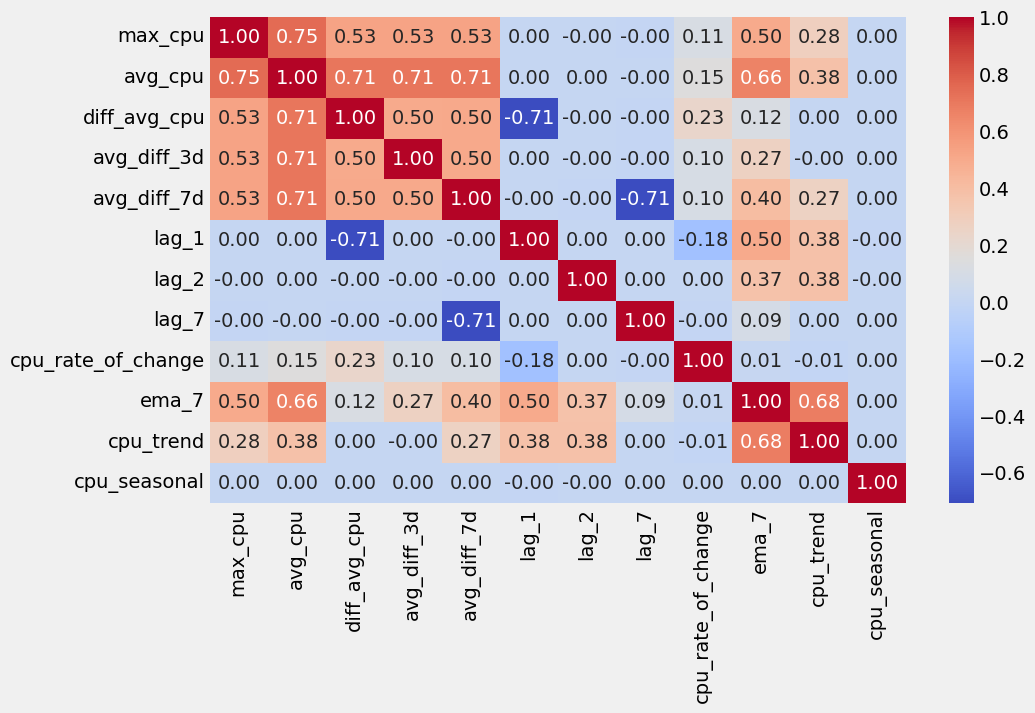

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = train_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [12]:
train_df.columns

Index(['max_cpu', 'avg_cpu', 'diff_avg_cpu', 'avg_diff_3d', 'avg_diff_7d',
       'lag_1', 'lag_2', 'lag_7', 'cpu_rate_of_change', 'ema_7', 'cpu_trend',
       'cpu_seasonal'],
      dtype='object')

In [13]:
scaler = MinMaxScaler((0,1))
columns_to_scale = ['max_cpu', 'avg_cpu', 'avg_diff_7d', 'lag_1', 'lag_7', 'cpu_rate_of_change', 'ema_7', 'cpu_seasonal','diff_avg_cpu']
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df_scaled[columns_to_scale] = scaler.fit_transform(test_df[columns_to_scale])

train_df_scaled = train_df_scaled[columns_to_scale]
test_df_scaled = test_df_scaled[columns_to_scale]
train_df_scaled.head(3)

,max_cpu,avg_cpu,avg_diff_7d,lag_1,lag_7,cpu_rate_of_change,ema_7,cpu_seasonal,diff_avg_cpu
9,0.216824,0.353702,0.429483,0.467304,0.494031,0.000241,0.445999,0.000000,0.443229
10,0.201917,0.529697,0.625317,0.353702,0.279707,0.000477,0.504805,0.846396,0.588355
11,0.017524,0.045404,0.049718,0.529697,0.942648,0.000027,0.376087,0.751099,0.257466


In [15]:
train_df_scaled.to_csv("../Datasets/preprocessed/Azure-vm-cpu-reading/train.csv");
test_df_scaled.to_csv("../Datasets/preprocessed/Azure-vm-cpu-reading/test.csv");